In [117]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import InterpolationMode
import os

In [118]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths
data_dir = "C:/Users/Owner/Desktop/Clark Hackathon/Code/Patches/A"  # your PATCHES folder (A/busy, A/free, B/busy...)

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),  # Required for VGG
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # Imagenet normalization
                         [0.229, 0.224, 0.225])
])

Using device: cuda


In [119]:
# Load data
dataset = datasets.ImageFolder(data_dir, transform=transform)
print("Class mapping:", dataset.class_to_idx)  # 'busy': 1, 'free': 0

# Split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

Class mapping: {'busy': 0, 'free': 1}


In [120]:
# Load pretrained VGG19
model = models.vgg19(pretrained=True)

# Freeze base layers
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier head
model.classifier[6] = nn.Linear(4096, 2)  # 2 output classes
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.classifier.parameters(), lr=0.0001)


In [121]:
# Training loop
def train(model, train_loader, val_loader, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}, Val Accuracy: {acc:.2f}%")

train(model, train_loader, val_loader, epochs=5)

Epoch 1/5, Loss: 2.0175, Val Accuracy: 99.84%
Epoch 2/5, Loss: 0.0606, Val Accuracy: 100.00%
Epoch 3/5, Loss: 0.0002, Val Accuracy: 100.00%
Epoch 4/5, Loss: 0.0001, Val Accuracy: 100.00%
Epoch 5/5, Loss: 0.0001, Val Accuracy: 100.00%


In [122]:
from collections import Counter

labels = [label for _, label in dataset]
print("Class distribution:", Counter(labels))


Class distribution: Counter({0: 3621, 1: 2550})


In [123]:
print(dataset.class_to_idx)


{'busy': 0, 'free': 1}


In [124]:
print(f"Train size: {len(train_ds)}, Val size: {len(val_ds)}")


Train size: 4936, Val size: 1235


In [125]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from sklearn.metrics import confusion_matrix, classification_report

# Load new dataset
new_data_dir = "C:/Users/Owner/Desktop/Clark Hackathon/Code/Patches/B"  # your PATCHES folder (A/busy, A/free, B/busy...)

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),  # Required for VGG
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # Imagenet normalization
                         [0.229, 0.224, 0.225])
])

new_dataset = datasets.ImageFolder(new_data_dir, transform=transform)
new_loader = DataLoader(new_dataset, batch_size=32, shuffle=False)

# Run predictions
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in new_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true += labels.cpu().tolist()
        y_pred += preds.cpu().tolist()

# Evaluate
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=new_dataset.classes))


[[4155  626]
 [ 178 1454]]
              precision    recall  f1-score   support

        busy       0.96      0.87      0.91      4781
        free       0.70      0.89      0.78      1632

    accuracy                           0.87      6413
   macro avg       0.83      0.88      0.85      6413
weighted avg       0.89      0.87      0.88      6413



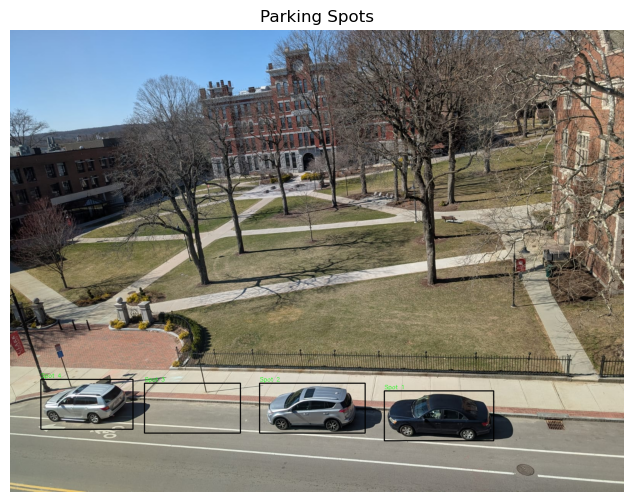

In [126]:
import matplotlib.pyplot as plt
import cv2

img_bgr = cv2.imread("C:/Users/Owner/Desktop/Clark Hackathon/Code/Clark/front.jpeg")

# Example bounding boxes [(x1, y1, x2, y2)]
parking_boxes = [
    (975, 940, 1260, 1070),
    (650, 920, 925, 1050),
    (350, 920, 600, 1050),
    (80, 910, 320, 1040)
]

for i, (x1, y1, x2, y2) in enumerate(parking_boxes):
    cv2.rectangle(img_bgr, (x1, y1), (x2, y2), (0, 0, 0), 2)
    cv2.putText(img_bgr, f"Spot {i+1}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

# Convert BGR to RGB
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Show using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.title("Parking Spots")
plt.axis("off")
plt.show()


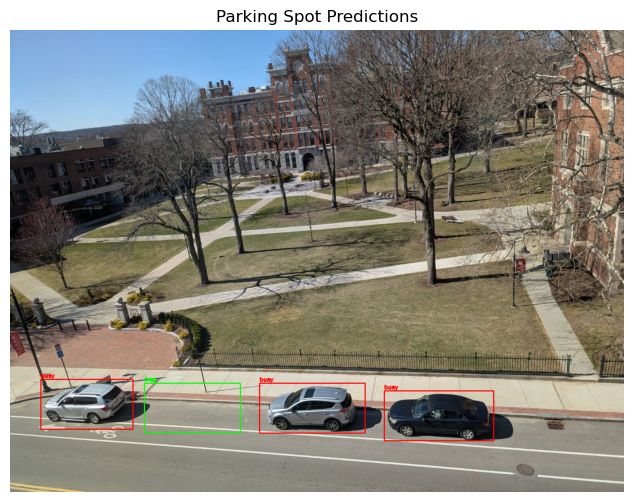

In [127]:
import cv2
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load original image
img_path = "C:/Users/Owner/Desktop/Clark Hackathon/Code/Clark/front.jpeg"
img_bgr = cv2.imread(img_path)

# Your verified parking spot boxes [(x1, y1, x2, y2)]
parking_boxes = [
    (975, 940, 1260, 1070),
    (650, 920, 925, 1050),
    (350, 920, 600, 1050),
    (80, 910, 320, 1040)
]

# VGG19 preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load trained model
# Make sure `model` is defined exactly like it was during training
# model.load_state_dict(torch.load("vgg19_parking.pt"))
model.eval()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Draw predictions
for i, (x1, y1, x2, y2) in enumerate(parking_boxes):
    # Crop and prepare image
    crop = img_bgr[y1:y2, x1:x2]
    crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
    crop_pil = Image.fromarray(crop_rgb)
    input_tensor = transform(crop_pil).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        _, pred = torch.max(output, 1)

    label = "busy" if pred.item() == 0 else "free"
    color = (0, 255, 0) if label == "free" else (0, 0, 255)  # Green or Red

    # Draw box and label
    cv2.rectangle(img_bgr, (x1, y1), (x2, y2), color, 2)
    cv2.putText(img_bgr, f"{label}", (x1, y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Convert and display result
img_rgb_result = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(img_rgb_result)
plt.title("Parking Spot Predictions")
plt.axis("off")
plt.show()


C:\Users\Owner\AppData\Local\Temp\ipykernel_28752\492741523.py:24: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  rect_points = np.int0(rect_points)       # Convert to int for drawing


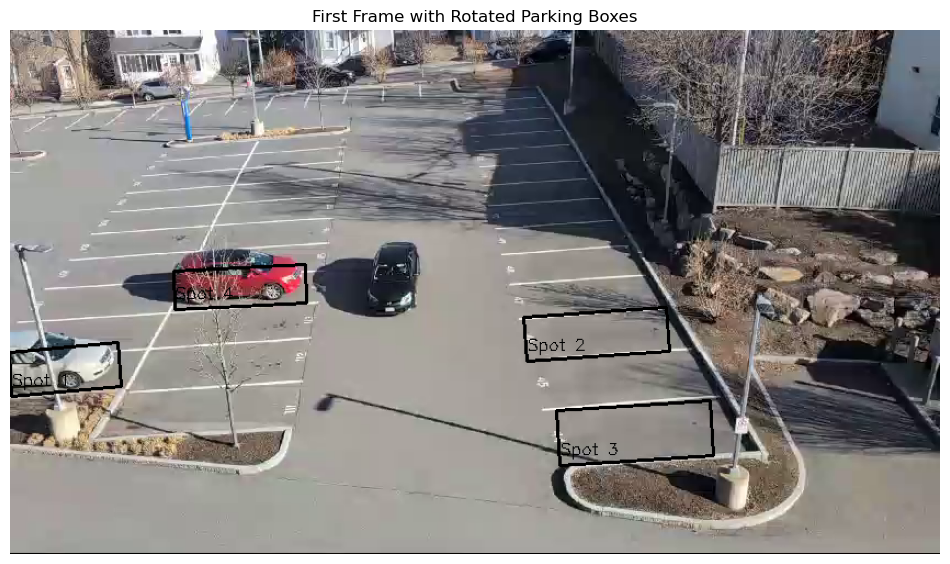

In [171]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Input path
video_path = "C:/Users/Owner/Desktop/Clark Hackathon/Code/Clark/clark_side.mp4"

# Define rotated parking boxes: ((center_x, center_y), (width, height), angle)
# Angle in degrees. Positive values = counter-clockwise rotation
rotated_boxes = [
    ((50, 310), (100, 40), -5),    # Slightly rotated left
    ((535, 278), (130, 40), -4),    # Slightly tilted right
    ((570, 368), (140, 50), -4),    # Straight box
    ((210, 235), (120, 35), -3)   # Tilted box
]

# Open video and read first frame
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()

if ret:
    for i, box in enumerate(rotated_boxes):
        rect_points = cv2.boxPoints(box)         # Get 4 corner points
        rect_points = np.int0(rect_points)       # Convert to int for drawing

        cv2.drawContours(frame, [rect_points], 0, (0, 0, 0), 2)
        cv2.putText(frame, f"Spot {i+1}", (rect_points[0][0], rect_points[0][1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    # Convert to RGB and display
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 8))
    plt.imshow(frame_rgb)
    plt.title("First Frame with Rotated Parking Boxes")
    plt.axis("off")
    plt.show()
else:
    print("Could not read the first frame.")

cap.release()


In [172]:
import cv2
import numpy as np

# Input & output paths
video_path = "C:/Users/Owner/Desktop/Clark Hackathon/Code/Clark/clark_side.mp4"
output_path = "C:/Users/Owner/Desktop/Clark Hackathon/Code/Clark/side_output.mp4"

# Define rotated boxes as: ((center_x, center_y), (width, height), angle)
rotated_boxes = [
    ((50, 310), (100, 40), -5),    # Slightly rotated left
    ((535, 278), (130, 40), -4),    # Slightly tilted right
    ((570, 368), (140, 50), -4),    # Straight box
    ((210, 235), (120, 35), -3)   # Tilted box
]

# Open the video
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Frame-by-frame processing
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Draw rotated boxes
    for i, box in enumerate(rotated_boxes):
        points = cv2.boxPoints(box)         # Get 4 corners
        points = np.int0(points)            # Convert to int
        cv2.drawContours(frame, [points], 0, (0, 0, 0), 2)  # Black box
        cv2.putText(frame, f"Spot {i+1}", (points[0][0], points[0][1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    # Write frame to output
    out.write(frame)

cap.release()
out.release()
print("Boxed video with rotated rectangles saved as:", output_path)


C:\Users\Owner\AppData\Local\Temp\ipykernel_28752\2076236758.py:35: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  points = np.int0(points)            # Convert to int


Boxed video with rotated rectangles saved as: C:/Users/Owner/Desktop/Clark Hackathon/Code/Clark/side_output.mp4


In [173]:
import cv2
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

# ==== Load Your Trained Model ====
# model = YourModelClass()
# model.load_state_dict(torch.load("vgg19_parking.pt"))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ==== Video Paths ====
video_path = "C:/Users/Owner/Desktop/Clark Hackathon/Code/Clark/clark_side.mp4"
output_path = "C:/Users/Owner/Desktop/Clark Hackathon/Code/Clark/side_final_output.mp4"

# ==== Rotated Boxes: ((center_x, center_y), (width, height), angle) ====
rotated_boxes = [
    ((50, 310), (100, 40), -5),    # Slightly rotated left
    ((535, 278), (130, 40), -4),    # Slightly tilted right
    ((570, 368), (140, 50), -4),    # Straight box
    ((210, 235), (120, 35), -3)   # Tilted box
]

# ==== VGG19 Preprocessing ====
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ==== Open Video ====
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# ==== Output Writer ====
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# ==== Frame-by-Frame Processing ====
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    for i, box in enumerate(rotated_boxes):
        # Get 4 corner points from rotated box
        rect_pts = cv2.boxPoints(box).astype(np.int32)

        # Crop the rotated region
        rect = cv2.minAreaRect(rect_pts)
        center, size, angle = rect
        size = (int(size[0]), int(size[1]))

        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(frame, M, (frame.shape[1], frame.shape[0]))
        crop_rotated = cv2.getRectSubPix(rotated, size, center)

        # Convert and predict
        crop_rgb = cv2.cvtColor(crop_rotated, cv2.COLOR_BGR2RGB)
        crop_pil = Image.fromarray(crop_rgb)
        input_tensor = transform(crop_pil).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            _, pred = torch.max(output, 1)
            label = "busy" if pred.item() == 0 else "free"
            color = (0, 0, 255) if label == "busy" else (0, 255, 0)

        # Draw box and label
        cv2.drawContours(frame, [rect_pts], 0, color, 2)
        cv2.putText(frame, label, (rect_pts[0][0], rect_pts[0][1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    out.write(frame)

# ==== Done ====
cap.release()
out.release()
print("Final rotated video saved at:", output_path)


Final rotated video saved at: C:/Users/Owner/Desktop/Clark Hackathon/Code/Clark/side_final_output.mp4


C:\Users\Owner\AppData\Local\Temp\ipykernel_28752\464640192.py:26: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  rect_points = np.int0(rect_points)       # Convert to int for drawing


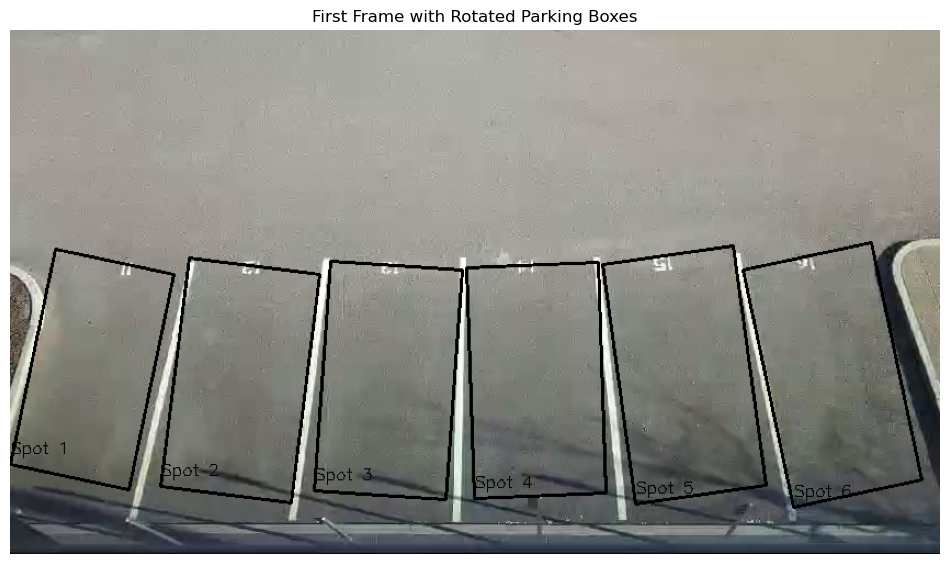

In [210]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Input path
video_path = "C:/Users/Owner/Desktop/Clark Hackathon/Code/Clark/clark_top.mp4"

# Define rotated parking boxes: ((center_x, center_y), (width, height), angle)
# Angle in degrees. Positive values = counter-clockwise rotation
rotated_boxes = [
    ((75, 310), (110, 200), 12),    # Slightly rotated left
    ((210, 320), (120, 210), 7),    # Slightly tilted right
    ((345, 320), (120, 210), 4),    # Straight box
    ((480, 320), (120, 210), -2),    # Slightly tilted right
    ((615, 315), (120, 220), -8),    # Straight box
    ((750, 315), (120, 220), -12)  # Tilted box
]

# Open video and read first frame
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()

if ret:
    for i, box in enumerate(rotated_boxes):
        rect_points = cv2.boxPoints(box)         # Get 4 corner points
        rect_points = np.int0(rect_points)       # Convert to int for drawing

        cv2.drawContours(frame, [rect_points], 0, (0, 0, 0), 2)
        cv2.putText(frame, f"Spot {i+1}", (rect_points[0][0], rect_points[0][1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    # Convert to RGB and display
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 8))
    plt.imshow(frame_rgb)
    plt.title("First Frame with Rotated Parking Boxes")
    plt.axis("off")
    plt.show()
else:
    print("Could not read the first frame.")

cap.release()

In [212]:
import cv2
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

# ==== Load Your Trained Model ====
# model = YourModelClass()
# model.load_state_dict(torch.load("vgg19_parking.pt"))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ==== Video Paths ====
video_path = "C:/Users/Owner/Desktop/Clark Hackathon/Code/Clark/clark_top.mp4"
output_path = "C:/Users/Owner/Desktop/Clark Hackathon/Code/Clark/top_final_output.mp4"

# ==== Rotated Boxes: ((center_x, center_y), (width, height), angle) ====
rotated_boxes = [
    ((75, 310), (110, 200), 12),    # Slightly rotated left
    ((210, 320), (120, 210), 7),    # Slightly tilted right
    ((345, 320), (120, 210), 4),    # Straight box
    ((480, 320), (120, 210), -2),    # Slightly tilted right
    ((615, 315), (120, 220), -8),    # Straight box
    ((750, 315), (120, 220), -12)  # Tilted box
]

# ==== VGG19 Preprocessing ====
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ==== Open Video ====
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# ==== Output Writer ====
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# ==== Frame-by-Frame Processing ====
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    for i, box in enumerate(rotated_boxes):
        # Get 4 corner points from rotated box
        rect_pts = cv2.boxPoints(box).astype(np.int32)

        # Crop the rotated region
        rect = cv2.minAreaRect(rect_pts)
        center, size, angle = rect
        size = (int(size[0]), int(size[1]))

        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(frame, M, (frame.shape[1], frame.shape[0]))
        crop_rotated = cv2.getRectSubPix(rotated, size, center)

        # Convert and predict
        crop_rgb = cv2.cvtColor(crop_rotated, cv2.COLOR_BGR2RGB)
        crop_pil = Image.fromarray(crop_rgb)
        input_tensor = transform(crop_pil).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            _, pred = torch.max(output, 1)
            label = "occupied" if pred.item() == 0 else "vacant"
            color = (0, 0, 255) if label == "occupied" else (0, 255, 0)

        # Draw box and label
        cv2.drawContours(frame, [rect_pts], 0, color, 2)
        cv2.putText(frame, label, (rect_pts[0][0], rect_pts[0][1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    out.write(frame)

# ==== Done ====
cap.release()
out.release()
print("Final rotated video saved at:", output_path)


Final rotated video saved at: C:/Users/Owner/Desktop/Clark Hackathon/Code/Clark/top_final_output.mp4


In [219]:
import pandas as pd
from haversine import haversine, Unit

# === Load your datasets ===
parking_df = pd.read_excel("C:/Users/Owner/Desktop/Clark Hackathon/parking_spaces.xlsx")       # parking_id, parking_space_name, latitude, longitude
buildings_df = pd.read_excel("C:/Users/Owner/Desktop/Clark Hackathon/buildings.xlsx")    # building_id, building_name, latitude, longitude
spaces_df = pd.read_excel("C:/Users/Owner/Desktop/Clark Hackathon/slots_available.xlsx")     # parking_id, spots_available

# === Input: Target building name ===
target_building = "COHEN LASRY HOUSE"

# === Get coordinates of target building ===
building_row = buildings_df[buildings_df['building_name'] == target_building]
if building_row.empty:
    print("Building not found.")
    exit()

building_coords = (building_row.iloc[0]['lat'], building_row.iloc[0]['log'])

# === Calculate distance to each parking garage ===
results = []
for _, row in parking_df.iterrows():
    garage_coords = (row['lat'], row['long'])
    distance_m = haversine(building_coords, garage_coords, unit=Unit.METERS)

    parking_id = row['parking_id']
    parking_name = row['parking_space']

    # Match available spots
    space_row = spaces_df[spaces_df["parking_id"] == parking_id]
    available_spots = int(space_row["slots_available"].values[0]) if not space_row.empty else 0

    results.append({
        "parking_name": parking_name,
        "distance_meters": round(distance_m),
        "available_spots": available_spots
    })

# === Sort by distance ===
sorted_results = sorted(results, key=lambda x: x["distance_meters"])

# === Output ===
print(f"\nClosest parking garages to: {target_building}\n")
for r in sorted_results:
    print(f"{r['parking_name']:35} | Distance: {r['distance_meters']:>4} m | Spots: {r['available_spots']}")



Closest parking garages to: COHEN LASRY HOUSE

Carriage House Parking Lot          | Distance:   63 m | Spots: 2
14 Charlotte Street                 | Distance:  110 m | Spots: 11
IDRISI Parking Lot                  | Distance:  165 m | Spots: 10
Kneller Garage                      | Distance:  190 m | Spots: 87
ASEC Parking                        | Distance:  267 m | Spots: 19
Triana Center of Arts Parking Lot   | Distance:  317 m | Spots: 12
15 Claremont Street                 | Distance:  376 m | Spots: 8
15 Maywood Street                   | Distance:  395 m | Spots: 24
520 park avenue                     | Distance:  638 m | Spots: 7


In [223]:
# === Generate Google Maps link for the closest parking garage ===
if sorted_results:
    # Find the matching row in parking_df
    closest_parking_name = sorted_results[0]['parking_name']
    closest_row = parking_df[parking_df['parking_space'] == closest_parking_name].iloc[0]

    lat = closest_row['lat']
    lng = closest_row['long']

    maps_link = f"https://www.google.com/maps/search/?api=1&query={lat},{lng}"
    print(f"\nGoogle Maps link to nearest garage ({closest_parking_name}):\n{maps_link}")
else:
    print("No parking garages found.")



Google Maps link to nearest garage (Carriage House Parking Lot):
https://www.google.com/maps/search/?api=1&query=42.252671,-71.82061
